In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# LOAD DATA 

In [81]:
titanic_data=pd.read_csv('desktop/titanic_train.csv') # Load both data sets at same time

# DATA ANALYSIS

/var/folders/70/lzz7xk4j5zg9dcjtyl9q_y300000gn/T/ipykernel_3992/38421848.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_data.corr(), cmap='YlGnBu')


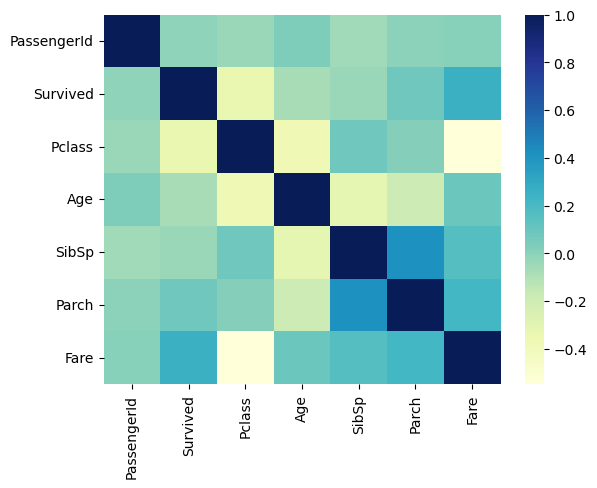

In [82]:
import seaborn as sns 

sns.heatmap(titanic_data.corr(), cmap='YlGnBu')
plt.show() #Add correlation numbers 

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit # Let's just use the presplit files

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

In [94]:
strat_train_set.info() # Always check null values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 516 to 396
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          576 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class Ageimputer(BaseEstimator,TransformerMixin): 
    
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X):
        imputer = SimpleImputer(strategy='mean')
        X['Age']= imputer.fit_transform(X[['Age']])
        return X

In [96]:
from sklearn.preprocessing import OneHotEncoder 

class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X):
        encoder = OneHotEncoder()
        matrix= encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ['C','S','Q','N']
        
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i]
            
        
        matrix= encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ['Female','Male']
        
        
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i]
            
        return X
    
    #Look into what the matrix looks like, data set merge 

In [97]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X):
        return X.drop(['Embarked', 'Name','Ticket','Cabin','Sex','N'], axis=1, errors='ignore')
    

In [98]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ageimputer',Ageimputer()),
                    ('featureencoder',FeatureEncoder()),
                    ('featuredropper',FeatureDropper())])

In [99]:
strat_train_set = pipeline.fit_transform(strat_train_set) #Let's try adding the classifier as the last step in the pipeline

In [100]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
516,517,1,2,34.000000,0,0,10.5000,0.0,0.0,1.0,1.0,0.0
306,307,1,1,29.389028,0,0,110.8833,1.0,0.0,0.0,1.0,0.0
686,687,0,3,14.000000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
536,537,0,1,45.000000,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
695,696,0,2,52.000000,0,0,13.5000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
275,276,1,1,63.000000,1,0,77.9583,0.0,0.0,1.0,1.0,0.0
740,741,1,1,29.389028,0,0,30.0000,0.0,0.0,1.0,0.0,1.0
534,535,0,3,30.000000,0,0,8.6625,0.0,0.0,1.0,1.0,0.0
424,425,0,3,18.000000,1,1,20.2125,0.0,0.0,1.0,0.0,1.0


In [101]:
from sklearn.preprocessing import StandardScaler # Use this scalar to transform the test data instead of training a new scalar 

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

X_data_test = scaler.transform(X_test)
y_data_test = y_test.to_numpy()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cabin
- Embarked
- Name
- Sex
- Ticket
Feature names seen at fit time, yet now missing:
- C
- Female
- Male
- Q
- S


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state= 99)

param_grid = [
    {'n_estimators':[10,100,200,500],'max_depth': [None,5,10],'min_samples_split':[2,3,4]}
    
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=99),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [103]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=500,
                       random_state=99)

In [104]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [105]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
35,36,0,1,42.000000,1,0,52.0000,0.0,0.0,1.0,0.0,1.0
454,455,0,3,30.993406,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
852,853,0,3,9.000000,1,1,15.2458,1.0,0.0,0.0,1.0,0.0
277,278,0,2,30.993406,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
77,78,0,3,30.993406,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
328,329,1,3,31.000000,1,1,20.5250,0.0,0.0,1.0,1.0,0.0
319,320,1,1,40.000000,1,1,134.5000,1.0,0.0,0.0,1.0,0.0
133,134,1,2,29.000000,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
730,731,1,1,29.000000,0,0,211.3375,0.0,0.0,1.0,1.0,0.0


In [106]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()

X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [107]:
final_clf.score(X_data_test,y_data_test)

0.8156424581005587

In [108]:
final_data = pipeline.fit_transform(titanic_data)

In [109]:
final_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [110]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()

X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [111]:
prod_clf = RandomForestClassifier()

param_grid = [
    {'n_estimators':[10,100,200,500],'max_depth': [None,5,10],'min_samples_split':[2,3,4]}
    
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_final, y_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [112]:
prod_final_clf = grid_search.best_estimator_

In [113]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=200)

In [114]:
titanic_test=pd.read_csv('desktop/test.csv')

In [115]:
final_titanic_test = pipeline.fit_transform(titanic_test)

In [116]:
final_titanic_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [117]:
X_final_test = final_titanic_test
X_final_test = X_final_test.fillna(method='ffill')

scaler = StandardScaler()
Final_final_data = scaler.fit_transform(X_final_test)

In [118]:
predictions = prod_final_clf.predict(Final_final_data)

/Users/Aryan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [119]:
final_df = pd.DataFrame(titanic_test['PassengerId'])
final_df['Survived'] = predictions

In [120]:
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1
